In [1]:
import re
import nltk
import spacy
import gensim
import nlp
import pandas as pd
import numpy as np
import pickle
from gensim.models import TfidfModel

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
with open('data/m-uniq/id2word', 'rb') as f:
    id2word = pickle.load(f)

In [4]:
with open('data/m-uniq/texts.pkl', 'rb') as f:
    texts = pickle.load(f)

In [5]:
corpus = [id2word.doc2bow(text) for text in texts]
len(corpus)

13701

In [6]:
print(id2word)

Dictionary<42894 unique tokens: ['abiotic_environment', 'across_environment', 'biology', 'bridge', 'cause']...>


# TF-IDF in scikit-learn

In [7]:
tfidf_vec = TfidfVectorizer(stop_words='english', max_df=0.1,min_df=0)
data = [" ".join(t) for t in texts]
tfidf_vec.fit(data)
tfidf = tfidf_vec.transform(data)

In [8]:
tfidf.shape

(13701, 42813)

In [9]:
# Sparcity
tfidf.nnz/np.prod(tfidf.shape)*100

0.09166595572467937

In [10]:
from sklearn import metrics
from collections import defaultdict
import os
def find_optimal_clusters(data, min_k=2, max_k=20, step=2, sparse=True):
    iters = range(min_k, max_k+1, step)
    
    sse = []
    scores = defaultdict(list)
    dense_data = data
    if (not sparse):
        dense_data = data.toarray()
    for k in iters:
        clusterer = MiniBatchKMeans(n_clusters=k,n_init=10, init_size=1024, batch_size=256*(os.cpu_count()-1), random_state=250, max_iter=5000, tol=1e-6)
        #clusterer = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=250, max_iter=5000, tol=1e-6, algorithm="elkan")
        cluster = clusterer.fit(data)        
        
        sse.append(cluster.inertia_)
        print('Fit {} clusters'.format(k))
        
                                   
        cluster_labels = cluster.predict(data)
        silhouette_avg = metrics.silhouette_score(data, cluster_labels)
        ch_score = metrics.calinski_harabasz_score(dense_data, cluster_labels)
        db_score = metrics.davies_bouldin_score(dense_data, cluster_labels)
        
        scores["SSE"].append(cluster.inertia_)
        scores["C_H_score"].append(ch_score)
        scores["D_B_score"].append(db_score)
        scores["Silhoutte"].append(silhouette_avg)

        print('The SSE is: {}'.format(cluster.inertia_))
        print('The average silhouette score is: {}'.format(silhouette_avg))
        print('The CH score is: {}'.format(ch_score))
        print('The DB score is: {}'.format(db_score))
        
        
    f, ax = plt.subplots(2, 2, figsize=(10,6))
    ax = ax.flatten()
    # ax[0].plot(iters, sse, marker='o')
    # ax[0].set_xlabel('Cluster Centers')
    # ax[0].set_xticks(iters)
    # ax[0].set_xticklabels(iters)
    # ax[0].set_ylabel('SSE')
    # ax[0].set_title('SSE by Cluster Center Plot')

    for i, (name, score) in enumerate(scores.items()):
        ax[i].plot(iters,score, marker='o')
        ax[i].set_xlabel('Cluster Centers')
        ax[i].set_xticks(iters)
        ax[i].set_xticklabels(iters)
        ax[i].set_ylabel(name)
        ax[i].set_title('{} by Cluster Center Plot'.format(name))

    return scores

Fit 2 clusters
The SSE is: 13414.808137594535
The average silhouette score is: 0.0031827679092979286
The CH score is: 17.85292032022872
The DB score is: 25.695985641073854
Fit 4 clusters
The SSE is: 13388.289313985077
The average silhouette score is: 0.00032255278707251966
The CH score is: 15.20116783878757
The DB score is: 22.628457899338102
Fit 6 clusters
The SSE is: 13360.02040564644
The average silhouette score is: 0.000238000081712949
The CH score is: 15.102062364997963
The DB score is: 19.683128045944787
Fit 8 clusters
The SSE is: 13424.982138265086
The average silhouette score is: -0.004447544914578662
The CH score is: 1.0970915223701716
The DB score is: 1.1495973490389453
Fit 10 clusters
The SSE is: 13423.11615433887
The average silhouette score is: -0.007162312580019394
The CH score is: 1.0153527450060478
The DB score is: 0.9873473498364543
Fit 12 clusters
The SSE is: 13421.143538220462
The average silhouette score is: -0.008974153422881107
The CH score is: 1.0132643863804534


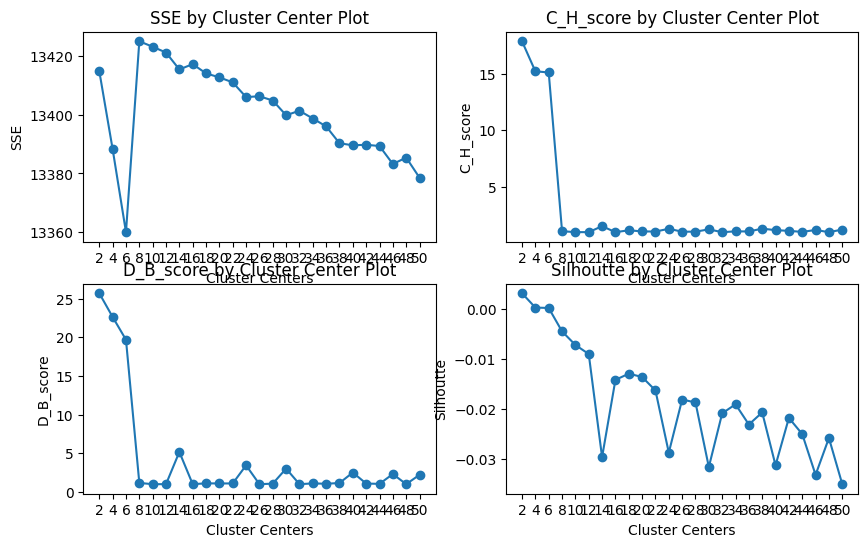

In [11]:
scores = find_optimal_clusters(tfidf,min_k=2,max_k=50,step=2, sparse=False)

In [12]:
#Dimensionality reduction with LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
#lsa = make_pipeline(PCA(n_components=200), Normalizer(copy=False))

X_lsa = lsa.fit_transform(tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 10.1%


In [14]:
X_lsa.shape

(13701, 100)

In [13]:
max_k=20

Fit 2 clusters
The SSE is: 12184.018540361643
The average silhouette score is: 0.01634961579810903
The CH score is: 216.72526898748555
The DB score is: 7.811366608298369
Fit 3 clusters
The SSE is: 12043.788355280554
The average silhouette score is: 0.016813279167417445
The CH score is: 190.18284275521867
The DB score is: 7.1619704044389
Fit 4 clusters
The SSE is: 11999.107241013247
The average silhouette score is: 0.014444467152317885
The CH score is: 143.21633663431695
The DB score is: 3.410300774361002
Fit 5 clusters
The SSE is: 11901.218083083088
The average silhouette score is: 0.016549214615799456
The CH score is: 139.5208538599656
The DB score is: 4.088092588581138
Fit 6 clusters
The SSE is: 11817.132473507369
The average silhouette score is: 0.011026449645939285
The CH score is: 129.70586652573206
The DB score is: 3.5656057655315467
Fit 7 clusters
The SSE is: 11512.211063848426
The average silhouette score is: 0.02709245349244663
The CH score is: 173.4287495186203
The DB score i

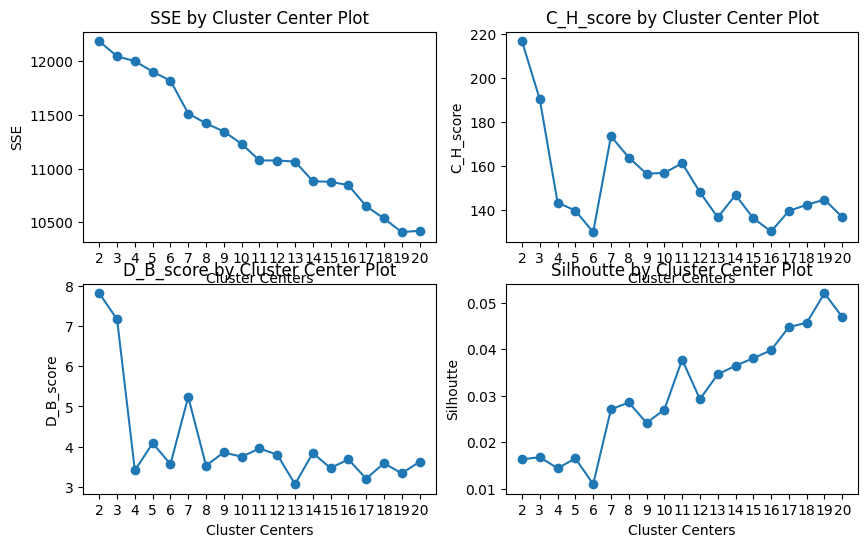

In [15]:
scores = find_optimal_clusters(X_lsa,min_k=2,max_k=max_k,step=1)

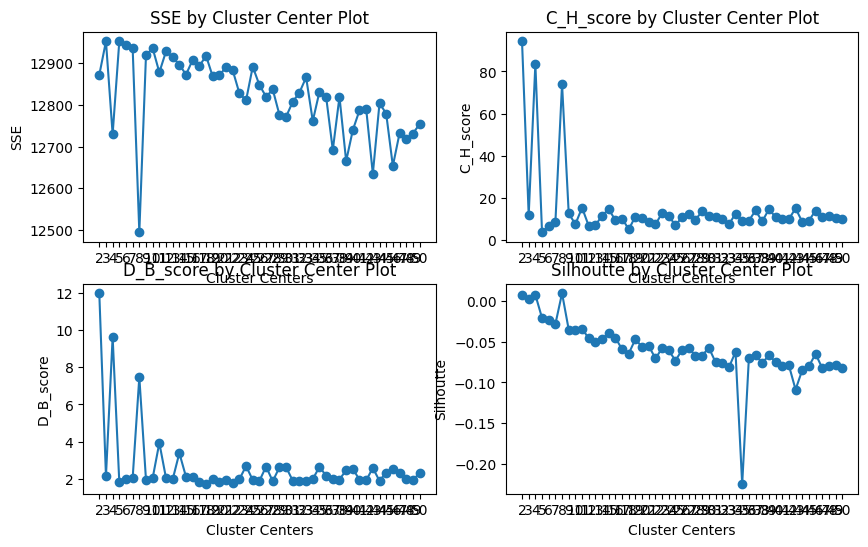

In [17]:
f, ax = plt.subplots(2, 2, figsize=(10,6))
ax = ax.flatten()
iters = range(2,max_k+1,1)
for i, (name, score) in enumerate(scores.items()):
    ax[i].plot(iters,score, marker='o')
    ax[i].set_xlabel('Cluster Centers')
    ax[i].set_xticks(iters)
    ax[i].set_xticklabels(iters)
    ax[i].set_ylabel(name)
    ax[i].set_title('{} by Cluster Center Plot'.format(name))    

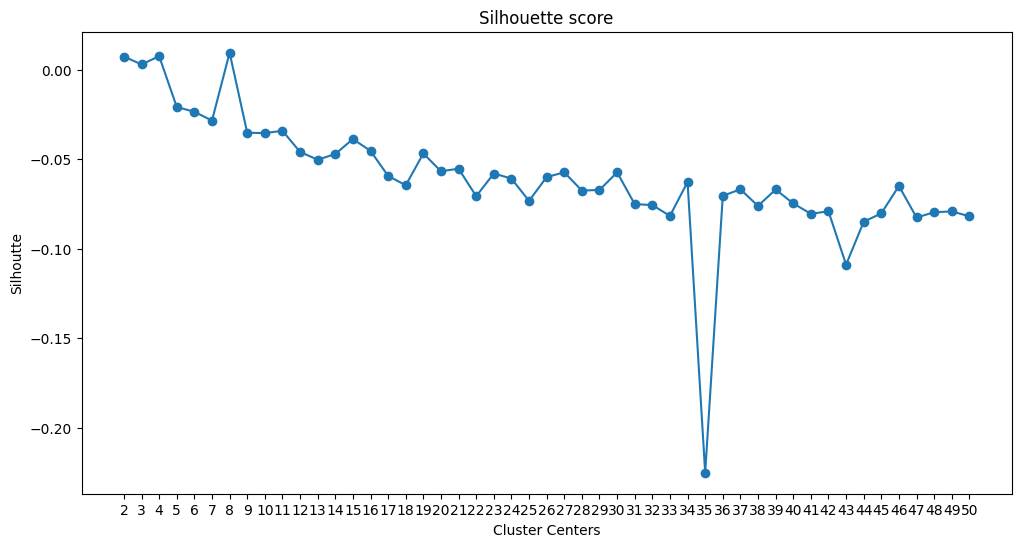

In [53]:
f, ax = plt.subplots(figsize=(12,6))
ax.plot(iters,scores["Silhoutte"], marker="o")
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel(name)
ax.set_title('Silhouette score')   
#plt.ylim(-0.12, 0.014)
f.savefig('images/silhouette-score.png',dpi=150)

In [ ]:
scores

In [17]:
best_k = 8#np.argmax(scores["Silhoutte"])+2
best_k

8

In [18]:
#clusters = MiniBatchKMeans(n_clusters=10, n_init=10, init_size=None, batch_size=256*(os.cpu_count()-1), 
#random_state=250, max_iter=5000, tol=1e-6, max_no_improvement=20).fit_predict(X_lsa)
clusters = KMeans(n_clusters=best_k, init='k-means++', n_init=10,random_state=250, max_iter=5000, tol=1e-6, algorithm='elkan').fit_predict(X_lsa)
clusters

array([1, 1, 6, ..., 7, 7, 0], dtype=int32)

In [19]:
clusters.shape

(13701,)

In [21]:
df = pd.read_csv("data/dimensions/publications-ecology-filtered-13701.csv")
df

,Unnamed: 0.1,Unnamed: 0,Rank,Publication ID,DOI,PMID,PMCID,ISBN,Title,Abstract,...,Fields of Research (ANZSRC 2020),RCDC Categories,HRCS HC Categories,HRCS RAC Categories,Cancer Types,CSO Categories,Units of Assessment,Sustainable Development Goals,GROUP,text
0,0,0,3366,pub.1148151862,10.1093/icb/icac055,35612972.0,NaN,NaN,An Integrative Perspective On the Mechanistic ...,It has long been known that the outcome of spe...,...,31 Biological Sciences; 3103 Ecology,NaN,NaN,NaN,NaN,NaN,A05 Biological Sciences,13 Climate Action,species interaction,An Integrative Perspective On the Mechanistic ...
1,1,1,3161,pub.1140217916,10.1086/716724,34762574.0,NaN,NaN,Species Interactions Limit the Predictability ...,Predicting how ecological communities will res...,...,31 Biological Sciences; 3103 Ecology,NaN,NaN,NaN,NaN,NaN,A05 Biological Sciences,14 Life Below Water,species interaction,Species Interactions Limit the Predictability ...
2,2,2,3133,pub.1152523368,10.1111/ele.14139,36335559.0,PMC10099232,NaN,Resetting our expectations for parasites and t...,"Despite the ubiquitous nature of parasitism, h...",...,31 Biological Sciences; 3103 Ecology; 41 Envir...,Infectious Diseases,NaN,2.1 Biological and endogenous factors,NaN,NaN,A05 Biological Sciences,14 Life Below Water,species interaction,Resetting our expectations for parasites and t...
3,3,3,3130,pub.1145194743,10.1111/ele.13977,35106910.0,PMC9543015,NaN,Disentangling key species interactions in dive...,Modelling species interactions in diverse comm...,...,31 Biological Sciences; 3103 Ecology,NaN,NaN,NaN,NaN,NaN,A05 Biological Sciences,NaN,species interaction,Disentangling key species interactions in dive...
4,4,4,3099,pub.1149534290,10.1111/nph.18384,35842790.0,PMC9804646,NaN,Impact of warmer and drier conditions on tree ...,Increased temperature and prolonged soil moist...,...,31 Biological Sciences; 3103 Ecology; 3108 Pla...,NaN,NaN,NaN,NaN,NaN,A05 Biological Sciences,13 Climate Action,species interaction,Impact of warmer and drier conditions on tree ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13696,13802,2618,312,pub.1005032511,10.1007/s10750-013-1716-1,NaN,NaN,NaN,Quantifying interspecific spatial overlap in a...,Levins’s asymmetrical α index quantifies betwe...,...,31 Biological Sciences; 3103 Ecology; 41 Envir...,NaN,NaN,NaN,NaN,NaN,B09 Physics,NaN,interspecific interaction,Quantifying interspecific spatial overlap in a...
13697,13804,2620,284,pub.1034372806,10.2478/v10208-011-0015-3,NaN,NaN,NaN,A gradient analytic perspective on distributio...,Abstract After massive proliferation over the ...,...,31 Biological Sciences; 3103 Ecology,NaN,NaN,NaN,NaN,NaN,A05 Biological Sciences,NaN,interspecific interaction,A gradient analytic perspective on distributio...
13698,13805,2621,261,pub.1029922063,10.3727/015613880791573853,NaN,NaN,NaN,A Comparison of Two Populations of the Grey-cr...,Group-breeding is defined as breeding behaviou...,...,31 Biological Sciences; 3103 Ecology; 3109 Zoo...,NaN,NaN,NaN,NaN,NaN,"A06 Agriculture, Veterinary and Food Science",NaN,interspecific interaction,A Comparison of Two Populations of the Grey-cr...
13699,13806,2622,252,pub.1147285073,10.1111/1365-2745.13895,NaN,NaN,NaN,Temporal stabilizing effects of species richne...,The extent to which individuals experience int...,...,31 Biological Sciences; 3103 Ecology,NaN,NaN,NaN,NaN,NaN,A05 Biological Sciences,14 Life Below Water,interspecific interaction,Temporal stabilizing effects of species richne...


In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
def plot_tsne_pca(data, labels, groups):
    max_label = max(labels)+1
    #max_items = np.random.choice(range(data.shape[0]), size=6000, replace=False)
    
    #pca = PCA(n_components=2).fit_transform(np.asarray(data[max_items,:].todense()))        
    #pipeline = make_pipeline(Normalizer(copy=False), PCA(n_components=2))
    #pca = pipeline.fit_transform(np.asarray(data.todense()))
    pca = PCA(n_components=2).fit_transform(data)
    
    #idx = np.random.choice(range(pca.shape[0]), size=6000, replace=False)
    label_subset = labels
    #label_subset = [cm.hsv((i)/max_label) for i in label_subset[idx]]
    label_subset = [cm.hsv((i)/max_label) for i in label_subset]
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
    
    #ax1.scatter(pca[idx,0], pca[idx, 1], c=label_subset, s=1, alpha=0.4)
    scatter = ax1.scatter(pca[:,0], pca[:, 1], c=labels, s=2, alpha=1, cmap="Set1")
    ax1.set_title('PCA Cluster Plot')    
    ax1.legend(*scatter.legend_elements(),
               #labels=[f"Cluster {i}".format(i) for i in range(0,max_label)],
               title="Clusters", loc="upper right")
    
    #ax2.scatter(pca[idx,0], pca[idx, 1], c=groups[idx], s=1, alpha=1, cmap="Set3")    
    groups_color = {
        "species interaction": 0,
        "biotic interaction" : 1,
        "ecological interaction":2,
        "interspecific interaction": 3,
        "community interaction":  4,
        "biological interaction": 5
    }
    scatter = ax2.scatter(pca[:,0], pca[:, 1], c=[groups_color[c] for c in groups], s=2, alpha=1, cmap="Set1")
    ax2.set_title('PCA Cluster Plot By Group')    
    ax2.legend(scatter.legend_elements()[0], groups_color)
    
    f.savefig('images/cluster-pca.png', dpi=150)
    plt.show()

    return pca

In [23]:
groups = df["GROUP"]
np.array(groups.unique())

array(['species interaction', 'biotic interaction',
       'ecological interaction', 'community interaction',
       'biological interaction', 'interspecific interaction'],
      dtype=object)

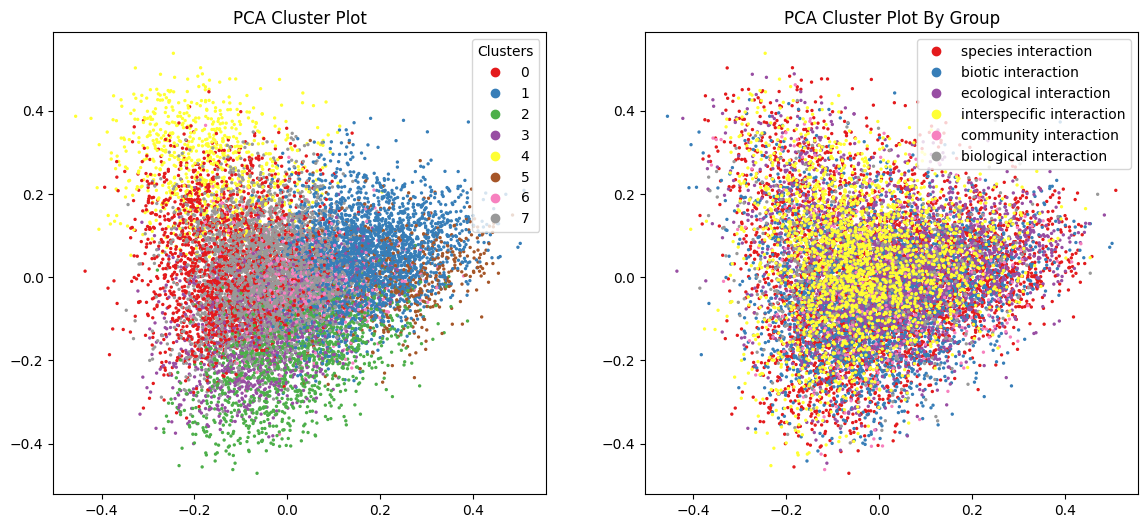

In [24]:
pca = plot_tsne_pca(X_lsa, clusters, groups)

In [25]:
groups = df["GROUP"].copy()
groups.loc[(groups!="biological interaction") & (groups!="community interaction")] = "1"
groups.loc[(groups=="biological interaction") | (groups=="community interaction")] = "0"
groups.unique()

array(['1', '0'], dtype=object)

In [26]:
groups = df["GROUP"].astype("category")
group_ids = pd.factorize(groups)[0]
idx = group_ids == 1
groups[idx].iloc[0]

'biotic interaction'

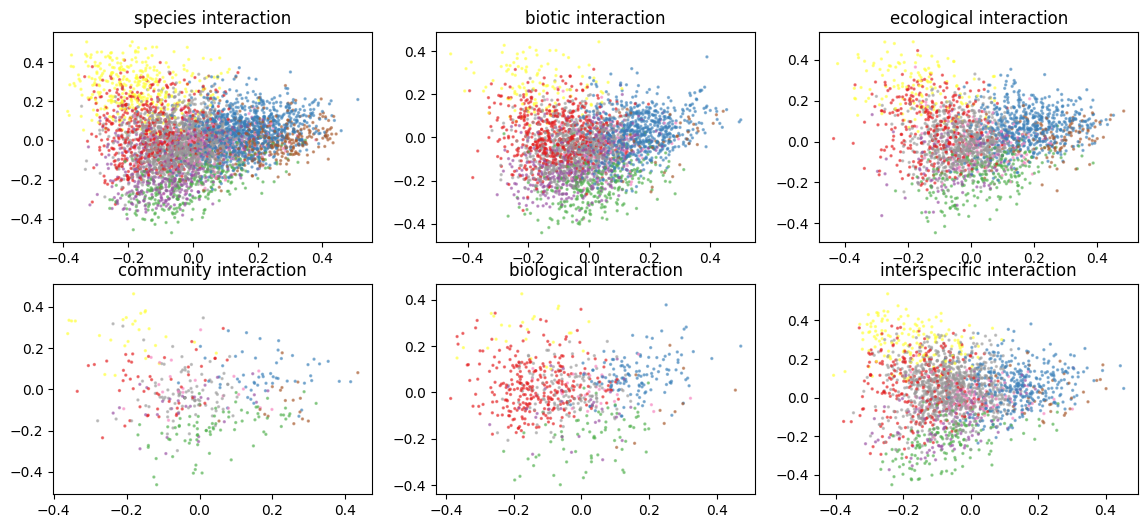

In [27]:
groups = df["GROUP"].astype("category")
group_ids = pd.factorize(groups)[0]
max_label = max(clusters)+1           
label_subset = clusters

fig, axes  = plt.subplots(2,3, figsize=(14,6))
for i, ax in enumerate(axes.flatten()):    
    idx = group_ids == i    
    #colors = [cm.hsv(i/max_label) for i in label_subset[idx]]
    ax.scatter(pca[idx,0], pca[idx, 1], c=label_subset[idx], s=2, alpha=0.5, cmap="Set1")    
    ax.set_title('{}'.format(groups[idx].iloc[0]))   
fig.savefig('images/cluter-by-term.png',dpi=150)
plt.show()

In [35]:
groups = [ s.replace(' interaction','') for s in groups]
groups[:5]

['species', 'species', 'species', 'species', 'species']

In [36]:
df_grp = pd.DataFrame({'group':groups,'cluster':clusters})
counts = df_grp.groupby(['group', 'cluster']).size().reset_index(name="n")
counts = counts.pivot(index='group', columns='cluster', values='n')
counts

cluster,0,1,2,3,4,5,6,7
group,,,,,,,,
biological,288,128,71,35,25,10,26,145
biotic,556,679,325,442,117,42,104,853
community,52,54,79,30,27,17,21,97
ecological,325,561,255,128,134,114,131,717
interspecific,272,356,161,126,148,39,123,963
species,560,1059,339,569,357,309,228,1504


In [29]:
counts[i]

group
biological interaction        10
biotic interaction            42
community interaction         17
ecological interaction       114
interspecific interaction     39
species interaction          309
Name: 5, dtype: int64

0
1
2
3
4
5
6
7


/tmp/ipykernel_530601/2208279749.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')


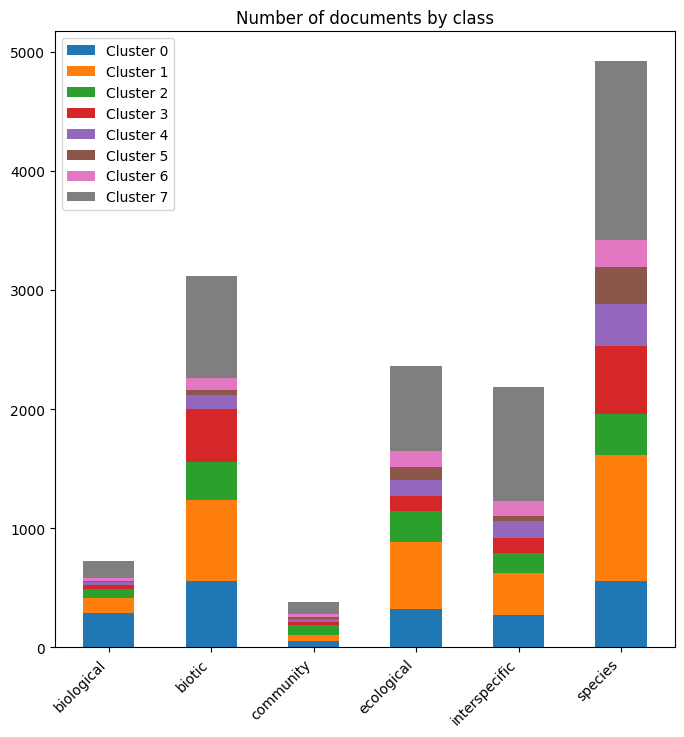

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
bottom = np.zeros(6)
for i in range(0,counts.shape[1]):
    print(i)    
    p = ax.bar(counts.index,counts[i],0.5,label=f"Cluster {i}", bottom=bottom)
    bottom += counts[i]

ax.set_title("Number of documents by class")
ax.legend(loc="upper left")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')

fig.savefig('images/num-doc-by-cluster-by-term.png', dpi=150)
plt.show()
    


In [385]:
counts.index[0]



'biological interaction'

In [31]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


In [41]:
pd.DataFrame(tfidf.todense()).groupby(clusters).mean()

,0,1,2,3,4,5,6,7,8,9,...,16667,16668,16669,16670,16671,16672,16673,16674,16675,16676
0,0.000000,0.000000,0.000326,0.000000,0.000000,0.000000,0.005196,0.000000,0.000292,0.000000,...,0.000000,0.000000,0.000314,0.000213,0.000000,0.000000,0.000000,0.000279,0.000000,0.000227
1,0.000527,0.000098,0.000412,0.000078,0.000202,0.000418,0.003180,0.000098,0.000041,0.000054,...,0.000373,0.000175,0.000065,0.000502,0.000075,0.000235,0.000170,0.000171,0.000388,0.000301
2,0.000000,0.000000,0.000077,0.000153,0.000148,0.000000,0.003678,0.000047,0.000046,0.000076,...,0.000047,0.000074,0.000000,0.000156,0.000036,0.000000,0.000040,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000553,0.000000,0.000145,0.000144,0.004088,0.000000,0.000000,0.000324,...,0.000149,0.000168,0.000000,0.000264,0.000000,0.000000,0.000000,0.000000,0.000121,0.000000
4,0.000000,0.000000,0.000449,0.000404,0.000271,0.000000,0.005669,0.000000,0.000428,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000227,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000260,0.000000,0.000000,0.000000,0.002428,0.000000,0.000000,0.000000,...,0.000228,0.000000,0.000000,0.000239,0.000194,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000955,0.000000,0.000000,0.000000,0.004463,0.000345,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000177,0.000366,0.000135,0.000159,0.000271,0.003357,0.000000,0.000139,0.000000,...,0.000000,0.000000,0.000449,0.000293,0.000162,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
get_top_keywords(tfidf, clusters, tfidf_vec.get_feature_names_out(), 5)


Cluster 0
phytoplankton,sediment,stream,water,fish

Cluster 1
biodiversity,evolution,environmental,ecology,trait

Cluster 2
bacterial,root,microbial,bacteria,soil

Cluster 3
warm,growth,temperature,tree,climate

Cluster 4
forage,predation_risk,predation,prey,predator

Cluster 5
specialization,pollinator_network,network_structure,modularity,network

Cluster 6
host_parasite,parasitism,infection,parasite,host

Cluster 7
bird,seed,herbivore,pollinator,native
